In [1]:
import time
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import h5py

from dipy.tracking import eudx
from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel, quantize_evecs
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines, transform_streamlines
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy

from dipy.tracking import utils

import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper

Using TensorFlow backend.


In [37]:
pTrainData_fibrePrediction = 'train_prediction_grid_normalized_dti_cs1_wholebrain.h5'
pTrainData_fibreTracking = 'train_tracking_grid_normalized_dti_cs1_wholebrain.h5'
pTrainInput = 'train_input_normalized_dti_cs1_wholebrain_'
noCrossings = 3

In [150]:
import os
print(os.getcwd())

/home/nico/Code/deepFibreTracking


# Preprocessing

crop multi-shell DWI to single shell data

In [73]:
bvals,bvecs,gtab,dwi,aff,t1,binarymask = dwi_tools.loadHCPData('100307')
dwi_subset, gtab_subset, bvals_subset, bvecs_subset = dwi_tools.cropDatsetToBValue(3000, bvals, bvecs, dwi)

The average b0 image is required for data normalization.

In [72]:
b0_idx = bvals < 10 # 10/02/18 NH: changed to work with HCP data
b0 = dwi[..., b0_idx].mean(axis=3)

In [81]:
dwi_singleShell = np.concatenate((dwi_subset, dwi[..., b0_idx]), axis=3)
bvals_singleShell = np.concatenate((bvals_subset, bvals[..., b0_idx]), axis=0)
bvecs_singleShell = np.concatenate((bvecs_subset, bvecs[b0_idx,]), axis=0)
gtab_singleShell = gradient_table(bvals=bvals_singleShell, bvecs=bvecs_singleShell, b0_threshold = 10)

# Tractography

In this section we'll generate streamlines using different approaches. This is gonna be the foundation for the evaluation of our method. We'll also employ simulated as well as curated data for our analysis.

In [49]:
# roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39)) #  splenium of the corpus callosum
from dipy.tracking.utils import random_seeds_from_mask, seeds_from_mask
ccmask, options = nrrd.read('100307/100307-ccSegmentation.nrrd')
ccseeds = seeds_from_mask(ccmask, affine=aff)
wholebrainseeds = seeds_from_mask(binarymask, affine=aff)
validationSeeds = ccseeds[45:48]
rndseeds = random_seeds_from_mask(binarymask, seeds_count=4000, seed_count_per_voxel=False, affine=aff)

## Import preprocessed data

In [28]:
import nibabel as nib
f = nib.streamlines.load('100307_new/tracts.trk', lazy_load=False)

/home/nico/anaconda3/lib/python3.6/site-packages/nibabel/streamlines/trk.py:92: RuntimeWarning: divide by zero encountered in true_divide
  scale[range(3), range(3)] /= header[Field.VOXEL_SIZES]


In [32]:
import nibabel as nib
f = nib.streamlines.load('/home/nico/tract.trk', lazy_load=False)

/home/nico/anaconda3/lib/python3.6/site-packages/nibabel/streamlines/trk.py:92: RuntimeWarning: divide by zero encountered in true_divide
  scale[range(3), range(3)] /= header[Field.VOXEL_SIZES]


In [33]:
sl = f.streamlines

## Single Tensor Model

In [119]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_model = dti.TensorModel(gtab_singleShell, fit_method='WLS')
dti_fit = dti_model.fit(dwi_singleShell)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

Runtime 414.63745164871216s


In [107]:
#TODO: not necessary in the future, replace with own function
sphere = get_sphere('symmetric724')
start_time = time.time()
dtipeaks = peaks_from_model(model=dti_model,
                            data=dwi_singleShell,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False,
                            npeaks=5
                           )
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

Runtime 1630.9659328460693s


In [127]:
dti_fit.evecs[70,75,70,]

array([[-0.99901612, -0.04371742, -0.00745568],
       [-0.03151777,  0.58160646,  0.81285949],
       [ 0.03119985, -0.81229472,  0.5824121 ]])

In [140]:
dtiPeakDirs = dtipeaks.peak_dirs[:,:,:,0,:]

In [141]:
dtiPeakDirs.shape

(145, 174, 145, 3)

In [154]:
from dipy.direction import PeaksAndMetrics, PeaksAndMetricsDirectionGetter
#dipy.direction.PeaksAndMetricsDirectionGetter
class PAMdti(PeaksAndMetricsDirectionGetter):
    def __init__(self, evecs, evals):
        dx,dy,dz,deval = evals.shape
        self.peak_dirs = evecs
        self.peak_values = evals
        self.peak_indices = -1 * np.ones([dx,dy,dz,deval])
        self.peak_indices[:,:,:,1] = 1
    #def initial_direction(self, s):
    #    return peak_dirs[]

In [155]:
p2 = PAMdti(dti_fit.evecs, dti_fit.evals)

In [ ]:
from dipy.tracking.local import BinaryTissueClassifier
binary_classifier = BinaryTissueClassifier(binarymask == 1)
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .2)
streamline_generator = LocalTracking(p2, classifier, ccseeds, aff, step_size=.1) #wholebrainseeds
streamlines = Streamlines(streamline_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 20)

In [117]:
dwi_tools.visStreamlines(streamlines_filtered,t1)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [ ]:
tensors = dti_fit.quadratic_form
tensors = tensors.reshape( (tensors.shape[:-2] + (-1,) ) )

peaks based on tensor model

create data given the eigenvectors and eigenvalues of the single tensor model

In [ ]:
dataSz = np.append(fit_wls.evecs.shape[0:3],9)
data_evecs = np.concatenate((np.reshape(fit_wls.evecs, dataSz), fit_wls.evals), axis=3)

In [ ]:
csa_model = CsaOdfModel(gtab_subset, sh_order=4)

peaks based on spherical harmonics

In [ ]:
csa_model = CsaOdfModel(gtab_subset, sh_order=4)
sphere = get_sphere('symmetric724')
start_time = time.time()
csa_peaks = peaks_from_model(model=csa_model,
                                     data=dwi_subset,
                                     sphere=sphere,
                                     relative_peak_threshold=.5,
                                     min_separation_angle=25,
                                     mask=binarymask,
                                     return_odf=False,
                                     normalize_peaks=False,
                                     npeaks=5,
                                     parallel=True,
                                     nbr_processes=6)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')
classifier = ThresholdTissueClassifier(csa_peaks.gfa, .25)

reconstruct streamlines

In [ ]:
from dipy.data import default_sphere
from dipy.direction import DeterministicMaximumDirectionGetter
start_time = time.time()
detmax_dg = DeterministicMaximumDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                             max_angle=30.,
                                                             sphere=sphere)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
from dipy.tracking.local import BinaryTissueClassifier

#binary_classifier = BinaryTissueClassifier(binarymask == 1)
classifier = ThresholdTissueClassifier(dti_fit.fa, .01)
streamline_generator = LocalTracking(detmax_dg, classifier, ccseeds, aff, step_size=.1)
streamlines = list(streamline_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 40)

In [157]:
print(len(streamlines_filtered))

1042


In [158]:
from dipy.tracking.streamline import transform_streamlines
streamlines_imageCS = transform_streamlines(streamlines_filtered, np.linalg.inv(aff)) # project streamlines from RAS into image (voxel) coordinate system
#dwi_tools.visStreamlines(streamlines_imageCS,t1, vol_slice_idx = 75)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

In [177]:
dwi_tools.visStreamlines(streamlines_imageCS,t1)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


## Q-ball Reconstruction

In [ ]:
csamodel = CsaOdfModel(gtab, 4)
sphere = get_sphere('symmetric724')
start_time = time.time()
csapeaks = peaks_from_model(model=csamodel,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)

GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

Visualisation

In [105]:
dwi_tools.visStreamlines(streamlines_filtered_dg,t1)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


## Constrained Spherical Deconvolution

Use in case of b = 2,500 – 3,000 s/mm² data

In [93]:
response, ratio = auto_response(gtab_singleShell, dwi_singleShell, roi_radius=10, fa_thr=0.7)
print(response)
print(ratio)

(array([0.00105655, 0.00022533, 0.00022533]), 3045.5532)
0.2132728574041772


In [100]:
csd_model = ConstrainedSphericalDeconvModel(gtab_singleShell, response)
sphere = get_sphere('symmetric724')
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi_singleShell,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)
GFA = csd_peaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

Runtime 602.9026775360107 s / GFA.shape (145, 174, 145)


In [102]:
csd_fit = csd_model.fit(dwi_singleShell, mask=binarymask)

from dipy.direction import DeterministicMaximumDirectionGetter

detmax_dg = DeterministicMaximumDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                             max_angle=30.,
                                                             sphere=sphere)
streamlines_generator = LocalTracking(detmax_dg, classifier, ccseeds, aff, step_size=.1)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered_dg = dwi_tools.filterStreamlinesByLength(streamlines, 50)

In [104]:
classifier = ThresholdTissueClassifier(csd_peaks.gfa, .2)
streamlines_generator = LocalTracking(csd_peaks, classifier, ccseeds, aff, step_size=.1)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

### Store intermediate data

In [160]:
np.save(pTrainInput + "_sl_filt.npy",streamlines_imageCS)
np.save(pTrainInput + "_seeds.npy",ccseeds)

# Generate Training data

In [ ]:
del streamlines_filtered

In [ ]:
streamlines_imageCS = np.load(pTrainInput + "_sl_filt.npy")

In [171]:
import importlib
importlib.reload(dwi_tools)
import src.dwi_tools as dwi_tools
dwi_B0normalized = dwi_tools.normalize_dwi(dwi_singleShell, b0)

Percentage erroneous voxels: 0.04


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:51: RuntimeWarning: divide by zero encountered in true_divide
  
/home/nico/Code/deepFibreTracking/src/dwi_tools.py:51: RuntimeWarning: invalid value encountered in true_divide
  


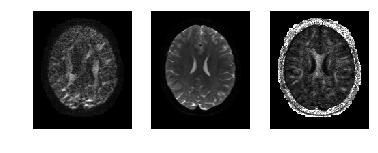

In [175]:
axial_middle = dwi_subset.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(dwi_subset[:, :, axial_middle, 1].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(b0[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(dwi_B0normalized[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.show()

In [179]:
noX = 1
noY = 1
noZ = 1
coordinateScaling = 1
sh_order = 4

In [181]:
# SPHERICAL HARMONICS
import importlib
importlib.reload(dwi_tools)
import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper

#del train_DWI,train_prevDirection, train_LikelyFibreDirections, train_nextDirection
data_sh, weights, b0 = dwi_tools.get_spherical_harmonics_coefficients(dwi_subset, b0=b0, bvals=bvals_subset, bvecs=bvecs_subset, sh_order = sh_order)

#rawData = data_evecs
rawData = data_sh
#rawData = tensors
#rawData = dtiPeakDirs

start_time = time.time()
train_DWI,train_prevDirection, train_LikelyFibreDirections, train_nextDirection = dwi_tools.generateTrainingData(streamlines_filtered, rawData, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossings)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Percentage erroneous voxels: 0.01


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:51: RuntimeWarning: divide by zero encountered in true_divide
  
/home/nico/Code/deepFibreTracking/src/dwi_tools.py:51: RuntimeWarning: invalid value encountered in true_divide
  


Processing streamlines
0/1042


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:372: RuntimeWarning: invalid value encountered in true_divide
  


100/1042
200/1042
300/1042
400/1042
500/1042


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:369: RuntimeWarning: invalid value encountered in true_divide
  


600/1042
700/1042
800/1042
900/1042
1000/1042
-> 782917
Runtime 353.2069134712219 s 


In [182]:
with h5py.File(pTrainData_fibrePrediction,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
    f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)   

In [ ]:
dwi_tools._euclToSpherical(-1*train_prevDirection[1,0],-1*train_prevDirection[1,1],-1*train_prevDirection[1,2])

In [ ]:
dwi_tools._euclToSpherical(train_prevDirection[1,0],train_prevDirection[1,1],train_prevDirection[1,2])

## Training

In [ ]:
noGPUs = 1
batch_size = 2**8
#batch_size -= batch_size % noGPUs # make batch size divisible by no. of GPUs
epochs = 50

In [ ]:
import h5py
import numpy as np
f = h5py.File(pTrainData_fibrePrediction, "r")
train_DWI = np.array(f["train_DWI"].value)
train_prevDirection = np.array(f["train_curPosition"].value)
train_likelyDirections = np.array(f["train_LikelyFibreDirections"].value)
train_nextDirection = np.array(f["train_NextFibreDirection"].value)
f.close()
#train_lastDirection = np.expand_dims(train_lastDirection, axis=1)

In [ ]:
np.polyfit(train_prevDirection[100,],train_nextDirection[100,],1)

In [ ]:
a,b = np.polyfit(train_prevDirection[101,],train_nextDirection[101,],1)

In [ ]:
train_prevDirection[100,]

In [ ]:
train_nextDirection[100,]

In [ ]:
vl = a*np.array([-0.1,-0.1,-0.1]) + b
vl

In [ ]:
vln = vl / np.sqrt(np.sum(vl**2))
vln

In [ ]:
vref = train_nextDirection[100,]
vref / np.sqrt(np.sum(vref**2))

In [ ]:
vref = train_prevDirection[100,]
vref / np.sqrt(np.sum(vref**2))

In [ ]:
plt.scatter(train_prevDirection[:,],train_nextDirection[:,])

### data normalization

In [ ]:
#train_LikelyFibreDirections = (train_LikelyFibreDirections + 1) / 2
#train_lastDirection = (train_lastDirection + 1) / 2
#train_DWI = nn_helper.normalizeDWI(train_DWI)
##train_lastDirection_unit = nn_helper.normalizeStreamlineOrientation(train_lastDirection)
##train_NextFibreDirection_unit = nn_helper.normalizeStreamlineOrientation(train_NextFibreDirection)

In [ ]:
train_nextDirection_sph = dwi_tools.convAllToSphCoords(train_nextDirection)
train_prevDirection_sph = dwi_tools.convAllToSphCoords(train_prevDirection)
train_nextDirection_sph[:,1] = (train_nextDirection_sph[:,1] + np.pi) / (2 * np.pi)
train_prevDirection_sph[:,1] = (train_prevDirection_sph[:,1] + np.pi) / (2 * np.pi)

## MLP / Bidirectional

simple

In [ ]:
# w/ DROPOUT and BN
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_simple = nn_helper.get_mlp_simpleTracker(activation_function = LeakyReLU(), features = 2048, inputShapeDWI=train_DWI.shape[1:5],depth = 5, noGPUs=noGPUs)
mlp_simple.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=200, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
mlp_simple_newNormalisation.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=200, verbose=2,validation_split=0.2, callbacks=[])

In [ ]:
# data scaled to [0,1]
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_simple_newNormalisation = nn_helper.get_mlp_simpleTracker(activation_function = LeakyReLU(), features = 128, inputShapeDWI=train_DWI.shape[1:5],depth = 3, noGPUs=noGPUs)
mlp_simple_newNormalisation.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=200, verbose=1,validation_split=0.2, callbacks=[])

advanced

In [ ]:
# w/ DROPOUT and BN
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_simple_newNormalisation = nn_helper.get_mlp_simpleTracker(activation_function = LeakyReLU(), features = 2048, inputShapeDWI=train_DWI.shape[1:5],depth = 3, noGPUs=noGPUs)
mlp_simple_newNormalisation.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=200, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
from keras.layers.advanced_activations import LeakyReLU

import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_adv = nn_helper.get_mlp_advancedTracker(activation_function = Activation('tanh'), features = 512, inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs, inputShapeStreamline=(3,1))
#mlp_adv.summary()
mlp_adv.fit([train_DWI,train_prevDirection], [train_NextFibreDirection], batch_size=batch_size, epochs=100, verbose=1,validation_split=0.2, callbacks=[])

### UNET / Bidirectional

In [ ]:
from keras import backend as K

def relu_advanced(x):
    return K.relu(x, max_value=1)

In [ ]:
from keras import backend as K
import tensorflow as tf
# see https://openreview.net/pdf?id=Hkuq2EkPf
def swish(x, c = 0.1):
    return x * K.sigmoid(tf.constant(c, dtype=tf.float32) * x)

max normalized DWI data

In [ ]:
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
import importlib
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
#unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=train_DWI.shape[1:5], depth = 3, noGPUs=2)
unet_tracker.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=20, verbose=1,validation_split=0.2, callbacks=[])

---

In [ ]:
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
import importlib
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
#unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=train_DWI.shape[1:5], depth = 3, noGPUs=2)
unet_tracker.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=20, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
idx = 1
praw,eraw = unet_tracker.predict([train_DWI[idx:idx+1,]])
p = (2 * np.pi) * p - np.pi
e = (2 * np.pi) * e - np.pi
print(str(  np.mean(    (praw-train_prevDirection_sph[idx:idx+1,])**2            )))
print(str(  np.mean(    (eraw-train_nextDirection_sph[idx:idx+1,])**2            )))

In [ ]:
unet_tracker.evaluate([train_DWI[idx:idx+1,]], [train_prevDirection_sph[idx:idx+1,],train_nextDirection_sph[idx:idx+1,]])

In [ ]:
x,y,z = dwi_tools.spheToEuclidean(1,p[0,0],p[0,1])
print(str([x,y,z]))
print(str(train_prevDirection[idx,]))
xv,yv,zv = dwi_tools.spheToEuclidean(1,(2*np.pi)*train_prevDirection_sph[idx,0]+np.pi,(2*np.pi)*train_prevDirection_sph[idx,1]+np.pi)
print(str([xv,yv,zv]))

In [ ]:
np.sqrt(np.sum((praw - train_prevDirection_sph[idx,])**2))

In [ ]:
unet_tracker.save('trackingNetwork_unet.h5')

In [ ]:
# duenner Klassifikations-Layer
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = Activation(swish), inputShapeDWI=train_DWI.shape[1:5], depth = 3, noGPUs=noGPUs)
unet_tracker.fit([train_DWI], [train_prevDirection,train_nextDirection], batch_size=batch_size, epochs=10, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
#### learnable activation layer
from keras.engine.base_layer import Layer
class LearnableSwishActivation(Layer):
    def __init__(self, **kwargs):
        super(LearnableSwishActivation, self).__init__(**kwargs)
        self.__name__ = 'SWISH'
        
    def build(self, input_shape):
        self.output_dim = input_shape[1] 
        self.W = self.add_weight(shape=(1,), # Create a trainable weight variable for this layer.
                                 initializer='one', trainable=True, name="swish_c")
        super(LearnableSwishActivation, self).build(input_shape)  # Be sure to call this somewhere!
    def call(self, x, mask=None):
        return x * K.sigmoid(self.W * x)
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.output_dim)

In [ ]:
import tensorflow as tf
x = tf.linspace(-5.,5.,10).eval(session=K.get_session())
y = swish(tf.linspace(-5.,5.,10),c=-0.1).eval(session=K.get_session())

In [ ]:
plt.plot(x,y);plt.show()

In [ ]:
# duenner Klassifikations-Layer, mit Dropout und BN
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = Activation(swish), inputShapeDWI=train_DWI.shape[1:5], depth = 3, noGPUs=noGPUs)
unet_tracker.fit([train_DWI], [train_prevDirection,train_nextDirection], batch_size=batch_size, epochs=200, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
import importlib
import keras
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
pModel = "tractography_model_{epoch:02d}-{val_loss:.6f}.h5"
#unet_tracker_2 = nn_helper.get_3Dunet_simpleTracker(activation_function = keras.layers.core.Activation('relu'), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
unet_tracker_2 = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
csv_logger = CSVLogger("tractography_log.csv")
checkpoint = ModelCheckpoint(pModel, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint, csv_logger]
unet_tracker_2.fit([train_DWI], [train_NextFibreDirection], batch_size=batch_size, epochs=100, verbose=1, validation_split=0.2, callbacks=[])

# DEBUG TRACKING

In [ ]:
noX = 16
noY = 16
noZ = 16

In [ ]:
import dipy.align.vector_fields as vfu
import tensorflow as tf
validationSeeds = ccseeds[0:1]
x_ = coordinateScaling * np.linspace(-8., 8., noX)
y_ = coordinateScaling * np.linspace(-8., 8., noY)
z_ = coordinateScaling * np.linspace(-8., 8., noZ)    
z_ = 1
noZ = 1

In [ ]:
noSeeds = len(validationSeeds)
noIterations = 1000
dw = 270

In [ ]:
streamlinePositions = np.zeros([noSeeds,noIterations+1,3])
streamlinePositions[:,0,] = validationSeeds[0:noSeeds]
streamlinePositions[:,1,] = validationSeeds[0:noSeeds]
x = np.zeros([noSeeds,noX,noY,noZ,dw])
iter = 1

In [ ]:
streamlinePositions[0,iter,]

In [ ]:
data=dwi_B0normalized
#model=msd_simple

In [ ]:
for j in range(0,noSeeds):
    coordVecs = np.vstack(np.meshgrid(x_,y_,z_, indexing='ij')).reshape(3,-1).T + streamlinePositions[j,iter,]
    for i in range(0,dw):
        x[j,:,:,:,i] = np.reshape(vfu.interpolate_scalar_3d(data[:,:,:,i],coordVecs)[0], [noX,noY,noZ])

In [ ]:
from scipy.ndimage import map_coordinates

In [ ]:
values_tmp = map_coordinates(data[:,:,:,10], coordVecs.T, order = 1)

In [ ]:
vals = np.reshape(values_tmp, [noX,noY,noZ])

In [ ]:
np.max(vals)

In [ ]:
coordVecs[0]

In [ ]:
coordVecs[1]

In [ ]:
coordVecs[-1]

In [ ]:
streamlinePositions

In [ ]:
plt.figure('Showing the datasets')
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data[62:78, 60:76, 62, 10].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(x[0,:,:,0,10].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(data[62:78, 60:76, 62, 10].T - x[0,:,:,0,10].T, cmap='gray', origin='lower')
plt.show()

In [ ]:
np.max(data[62:78, 60:76, 62, 10])

In [ ]:
np.max(x[0,:,:,0,10].T)

In [ ]:
np.min(data[62:78, 60:76, 62, 10].T - x[0,:,:,0,10].T)

In [ ]:
x.shape

In [ ]:
data.shape

In [ ]:
with tf.device('/cpu:0'):
    y2 = msd_simple.predict([x])
    #y3 = unet_tracker_2.predict([train_DWI[0:1,]])

In [ ]:
y2

In [ ]:
y2

In [ ]:
train_NextFibreDirection_unit[0]

In [ ]:
import keras
import keras.backend as K
keras.losses.mse(y,np.float32(train_NextFibreDirection_unit[0])).eval(session=K.get_session())

In [ ]:
from numpy import (array, dot, arccos, clip) 
from numpy.linalg import norm 

u = y
v = train_NextFibreDirection[0]
c = dot(u,v)/norm(u)/norm(v)
angle = arccos(clip(c, -1, 1)) 
angle

In [ ]:
u = nn_helper.denormalizeStreamlineOrientation(u)
v = nn_helper.denormalizeStreamlineOrientation(v)
c = dot(u,v)/norm(u)/norm(v)
angle = arccos(clip(c, -1, 1)) 
c

In [ ]:
yy = y / np.sqrt(np.sum(y ** 2))
yy

In [ ]:
vv = v / np.sqrt(np.sum(v ** 2))
vv

# Tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(dtipeaks, classifier, validationSeeds, np.identity(4), step_size=.1)
#streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, aff, step_size=.1)
streamlines_val = Streamlines(streamlines_generator)
streamlines_filtered_val = dwi_tools.filterStreamlinesByLength(streamlines, 50)

## MLP/Bidirectional Tracker

In [ ]:
validationSeeds

In [ ]:
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple,vNorms = tracking.applySimpleTrackerNetwork(useSph=True,seeds=validationSeeds,data=dwi_B0normalized, model=mlp_simple_newNormalisation, nnOutputToUse = 0, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple_2,vNorms2 = tracking.applySimpleTrackerNetwork(useSph=True,seeds=validationSeeds,data=dwi_B0normalized, model=mlp_simple_newNormalisation, nnOutputToUse = 1, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
streamlines_mlp_simple_f = np.fliplr(streamlines_mlp_simple)
streamlines_joined = np.concatenate([streamlines_mlp_simple_f,streamlines_mlp_simple_2],axis=1)

In [ ]:
streamlines_mlp_simple = streamlines_mlp_simple[0]
streamlines_mlp_simple_2 = streamlines_mlp_simple_2[0]
streamlines_mlp_simple_f = np.fliplr(streamlines_mlp_simple)
streamlines_joined = np.concatenate([streamlines_mlp_simple_f,streamlines_mlp_simple_2],axis=1)

In [ ]:
import src.dwi_tools as dwi_tools
importlib.reload(dwi_tools)
dwi_tools.visTwoSetsOfStreamlines(streamlines_val,streamlines_joined,t1[:,:,:], vol_slice_idx = 75, vol_slice_idx2 = 55)
#dwi_tools.visStreamlines(streamlines_val,t1, vol_slice_idx = 73)

In [ ]:
np.save('streamlines_validation.npy', streamlines_val)

In [ ]:
streamlines_val = np.load('streamlines_validation.npy')

In [ ]:
dwi_tools.visStreamlines(streamlines_msd_adv,t1, vol_slice_idx = 73)

### UNET/Bidirectional tracker

In [ ]:
unet_tracker.save('trackingNetwork.h5')

In [ ]:
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple,vNorms = tracking.applySimpleTrackerNetwork(useSph=True,seeds=validationSeeds,data=dwi_B0normalized, model=unet_tracker, nnOutputToUse = 0, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple_2,vNorms2 = tracking.applySimpleTrackerNetwork(useSph=True,seeds=validationSeeds,data=dwi_B0normalized, model=unet_tracker, nnOutputToUse = 1, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
streamlines_mlp_simple_f = np.fliplr(streamlines_mlp_simple)
streamlines_joined = np.concatenate([streamlines_mlp_simple_f,streamlines_mlp_simple_2],axis=1)

In [ ]:
import src.dwi_tools as dwi_tools
importlib.reload(dwi_tools)
dwi_tools.visTwoSetsOfStreamlines(streamlines_val,streamlines_joined,t1[:,:,:], vol_slice_idx = 75, vol_slice_idx2 = 55)
#dwi_tools.visStreamlines(streamlines_val,t1, vol_slice_idx = 73)

In [ ]:
plt.plot(vNorms.T)

In [ ]:
plt.plot(vNorms2.T)